In [1]:
# load dataset cross validation

In [2]:
import os

os.environ["CUDA_VISIBLE_DEVICES"]="1"

import json
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from imutils.paths import list_images
from sklearn.model_selection import train_test_split
from augmentations import avg_aug

%load_ext autoreload
%autoreload 2

In [11]:
np.sort(['printed', 'screen', 'bonafide'])

array(['bonafide', 'printed', 'screen'], dtype='<U8')

In [3]:
def _parse_function_with_DA(impath, label):
    # instantiate augmentation here to overcome "not-changing-random-seed" bug
    # this could lead to an speed decrease or an overheap, dont know
    aug = avg_aug() # think about deleting aug after use
    
    # image reading
    image = tf.io.read_file(impath)
    image = tf.io.decode_png(image, channels=3)
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, shape)
    image = tf.cast(image, tf.uint8)
    image = tf.numpy_function(func=aug.augment_image, inp=[image], Tout=tf.uint8)
    image = tf.cast(image, tf.float32)
    image = image / 255.
    
    # image = tf.clip_by_value(image, -1, 1)
    
    # label setting
    _split = tf.strings.split(impath, sep=os.sep)
    _cls = _split[-4]
    
    # if 'bonafide' in _split:
    #     lb = tf.cast([0, 1], tf.float32)
    # else:
    #     lb = tf.cast([1, 0], tf.float32)
    
    # 4th element is the class id
    if _cls == 'bonafide':
        lb = tf.cast([0, 1], tf.float32)
    else:
        lb = tf.cast([1, 0], tf.float32)
    
    return image, label

def _parse_function_without_DA(impath, label):
    # image reading
    image_string = tf.io.read_file(impath)
    image_decoded = tf.io.decode_png(image_string, channels=3)
    image = tf.cast(image_decoded, tf.float32)
    image = tf.image.resize(image, shape)
    image = image / 255.
    
    # image = tf.clip_by_value(image, -1, 1)
    
    # label setting
    _split = tf.strings.split(impath, sep=os.sep)
    _cls = _split[-4]
    
    # if 'bonafide' in _split:
    #     lb = tf.cast([0, 1], tf.float32)
    # else:
    #     lb = tf.cast([1, 0], tf.float32)
    
    # 4th element is the class id
    if _cls == 'bonafide':
        lb = tf.cast([0, 1], tf.float32)
    else:
        lb = tf.cast([1, 0], tf.float32)
    
    
    return image, label

# return tf.data
def load_dataset(
    db_dict=None, db_key='flickr', multiclass=False, 
    data_augmentation=False, shape=(224, 224), color='rgb', 
    load_csv=False, class_weights=False, batch_size=16
):
    
    db_dir = db_dict.get(db_key)
    _classes = ('attack', 'bonafide') if multiclass else ('bonafide', 'printed', 'screen')
    _bf_index = _classes.index('bonafide')
    imlist = [*list_images(db_dir)]
    bf_list, att_list = [], []
    
    for imdir in imlist:
        if _classes[_bf_index] in imdir.split(os.sep): # if 'bonafide' in imdir
            bf_list.append(imdir)
        else: # identify attack class
            att_list.append(imdir)
    
    if multiclass:
        pass
    else:
        bf_y = np.ones(len(bf_list))
        att_y = np.zeros(len(att_list)) # use labelencoder here
        # split|load data into train|test|val
        X = np.concatenate([att_list, bf_list])
        y = np.concatenate([bf_y, att_y])
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2
    
    # train dataset
    train_dataset = tf.cast(X_train, dtype=tf.string)
    train_dataset = tf.data.Dataset.from_tensor_slices((train_dataset, tf.cast(y_train, tf.float32)))
    train_dataset = train_dataset.shuffle(batch_size**2)
    train_dataset = train_dataset.map(_parse_function_with_DA, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    train_dataset = train_dataset.cache()
    train_dataset = train_dataset.batch(batch_size)
    
    # val dataset
    val_dataset = tf.cast(X_val, dtype=tf.string)
    val_dataset = tf.data.Dataset.from_tensor_slices((val_dataset, tf.cast(y_val, tf.float32)))
    val_dataset = val_dataset.shuffle(batch_size**2)
    val_dataset = val_dataset.map(_parse_function_without_DA, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    val_dataset = val_dataset.cache()
    val_dataset = val_dataset.batch(1)
    
    # test dataset
    test_dataset = tf.cast(X_test, dtype=tf.string)
    test_dataset = tf.data.Dataset.from_tensor_slices((test_dataset, tf.cast(y_test, tf.float32)))
    test_dataset = test_dataset.shuffle(batch_size**2)
    test_dataset = test_dataset.map(_parse_function_without_DA, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    test_dataset = test_dataset.cache()
    test_dataset = test_dataset.batch(1)
    
    return train_dataset, val_dataset, test_dataset

In [4]:
_classes = ('attack', 'bonafide')
_bf_index = _classes.index('bonafide')
shape = (224, 224)
batch_size = 16

In [5]:
datasets = {
    'flickr': '../data/02_intermediate/flickr',
    'splunk': '../data/02_intermediate/splunk'
}

In [6]:
train_ds, val_ds, test_ds = load_dataset(db_dict=datasets, db_key='splunk', batch_size=1)

2022-12-09 16:23:14.396522: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-09 16:23:14.426170: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-09 16:23:14.426924: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-09 16:23:14.427846: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

In [7]:
len(train_ds), len(test_ds), len(val_ds)

(14958, 4986, 4986)

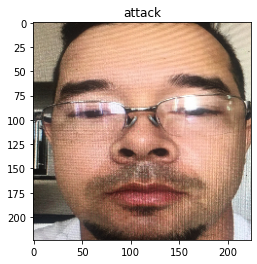

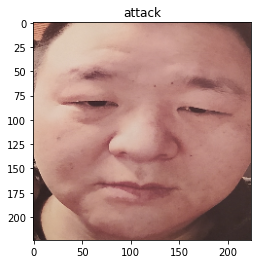

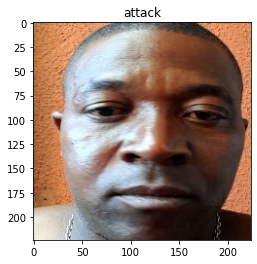

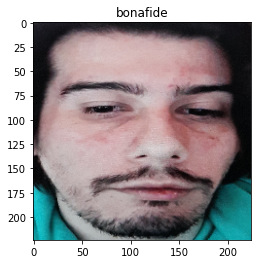

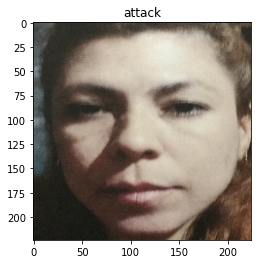

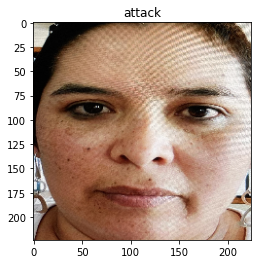

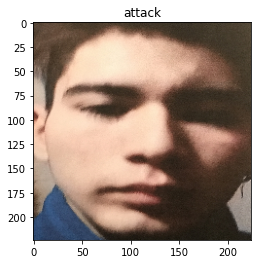

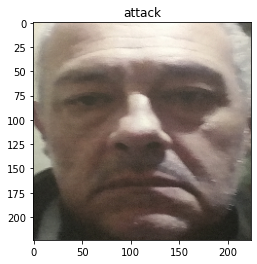

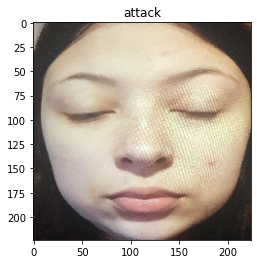

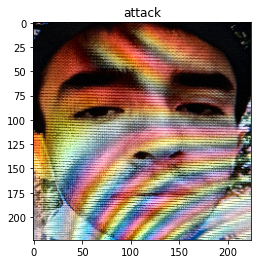

2022-12-09 16:23:17.540312: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [8]:
for bs in test_ds.take(10):
    im, lb = bs
    # plt.title(_classes[np.argmax(lb[0])])
    plt.title(_classes[int(lb[0])])
    plt.imshow(im[0])
    plt.show()

In [9]:
# separar identidades en base de datos flickr. Tienen un id asociado "F000xx"
# puta la wea splunk tambien